# 深層強化学習で画像入力のエージェントを学習させルーム

* gym を pip で入れた人は: pip install gym[atari]
* gym をgithubのソースから入れた人は gym ディレクトリで : pip install -e .[atari]

この他， 環境はpip install gym[ナントカ] で環境を追加できます [環境](https://github.com/openai/gym#environments)

In [2]:
# 数値計算に必須のもろもろ
import numpy as np

# 可視化パッケージ 
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

# seaborn を入れてない人は以下をコメントアウト
import seaborn as sns
sns.set_style('darkgrid')

In [9]:
# OpenAI Gym
import gym

# 利用できる全ての環境を表示
from gym import envs
print(envs.registry.all())

[EnvSpec(PredictActionsCartpole-v0), EnvSpec(Asteroids-ramDeterministic-v0), EnvSpec(Asteroids-ramDeterministic-v3), EnvSpec(Gopher-ramDeterministic-v3), EnvSpec(Gopher-ramDeterministic-v0), EnvSpec(DoubleDunk-ramDeterministic-v3), EnvSpec(DoubleDunk-ramDeterministic-v0), EnvSpec(Tennis-ramNoFrameskip-v3), EnvSpec(RoadRunner-ramDeterministic-v0), EnvSpec(Robotank-ram-v3), EnvSpec(CartPole-v0), EnvSpec(CartPole-v1), EnvSpec(Gopher-ram-v3), EnvSpec(Gopher-ram-v0), EnvSpec(Pooyan-ram-v0), EnvSpec(Pooyan-ram-v3), EnvSpec(SpaceInvaders-ram-v3), EnvSpec(CarRacing-v0), EnvSpec(SpaceInvaders-ram-v0), EnvSpec(YarsRevenge-ramDeterministic-v0), EnvSpec(SpaceInvadersDeterministic-v0), EnvSpec(DoubleDunk-ram-v3), EnvSpec(DoubleDunk-ram-v0), EnvSpec(SpaceInvadersDeterministic-v3), EnvSpec(Centipede-v3), EnvSpec(Centipede-v0), EnvSpec(Pitfall-ramNoFrameskip-v3), EnvSpec(Pitfall-ramNoFrameskip-v0), EnvSpec(Frostbite-ramNoFrameskip-v0), EnvSpec(Phoenix-ram-v3), EnvSpec(AmidarNoFrameskip-v3), EnvSpec(Sk

In [10]:
# 画像入力の環境を指定 （後でDQNをつかうため）
ENV_NAME ='Pong-v0'

# 環境の初期化
env = gym.make(ENV_NAME)
np.random.seed(123)
env.seed(123)

# インターフェイスの情報をもらっておく
nb_actions = env.action_space.n

print("# of Actions : {}".format(nb_actions))
print("Shape of Observation : {}".format(env.observation_space.shape))

[2017-02-20 03:48:33,526] Making new env: Pong-v0


# of Actions : 6
Shape of Observation : (210, 160, 3)


(210, 160, 3)


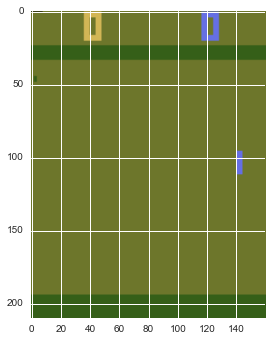

In [11]:
from rl.core import Processor

# Pillow が必要
from PIL import Image

INPUT_SHAPE = (84, 84)

class AtariProcessor(Processor):
    def process_observation(self, observation):
        assert observation.ndim == 3  # (height, width, channel)
        img = Image.fromarray(observation)
        img = img.resize(INPUT_SHAPE).convert('L')  # resize and convert to grayscale
        processed_observation = np.array(img)
        assert processed_observation.shape == INPUT_SHAPE
        return processed_observation.astype('uint8')  # saves storage in experience memory

    def process_state_batch(self, batch):
        processed_batch = batch.astype('float32') / 255.
        return processed_batch

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)
    
processor = AtariProcessor()

obs = env.reset()
plt.imshow(obs)
print(obs.shape)

In [12]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Convolution2D, Dense, Activation, Flatten, Permute
from rl.memory import SequentialMemory

# 深層パーセプトロン
WINDOW_LENGTH = 1
input_shape = (WINDOW_LENGTH,) + INPUT_SHAPE
model = Sequential()
if K.image_dim_ordering() == 'tf':
    # (width, height, channels)
    model.add(Permute((2, 3, 1), input_shape=input_shape))
elif K.image_dim_ordering() == 'th':
    # (channels, width, height)
    model.add(Permute((1, 2, 3), input_shape=input_shape))
else:
    raise RuntimeError('Unknown image_dim_ordering.')
model.add(Convolution2D(32, 8, 8, subsample=(4, 4)))
model.add(Activation('relu'))
model.add(Convolution2D(64, 4, 4, subsample=(2, 2)))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3, subsample=(1, 1)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())

# Memory Buffer
memory = SequentialMemory(limit=1000000, window_length=WINDOW_LENGTH)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
permute_2 (Permute)              (None, 84, 84, 1)     0           permute_input_3[0][0]            
____________________________________________________________________________________________________
convolution2d_4 (Convolution2D)  (None, 20, 20, 32)    2080        permute_2[0][0]                  
____________________________________________________________________________________________________
activation_6 (Activation)        (None, 20, 20, 32)    0           convolution2d_4[0][0]            
____________________________________________________________________________________________________
convolution2d_5 (Convolution2D)  (None, 9, 9, 64)      32832       activation_6[0][0]               
___________________________________________________________________________________________

In [7]:
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy
from rl.agents import DQNAgent
from keras.optimizers import Adam

# 線形にランダム選択確率を減少させる方策
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(),
                              attr='eps',
                              value_max=1.,
                              value_min=.1,
                              value_test=.05,
                              nb_steps=1000000)

# DQN エージェントを作成
dqn = DQNAgent(model=model,
               nb_actions=nb_actions,
               policy=policy,
               memory=memory,
               processor=processor,
               nb_steps_warmup=1000,
               gamma=.99,
               target_model_update=1000,
               train_interval=4,
               delta_clip=1.)

optimizer = Adam(lr=.0001, epsilon=0.0001)
dqn.compile(optimizer=optimizer, metrics=['mae'])

In [8]:
from rl.callbacks import Callback, TestLogger, ModelIntervalCheckpoint

# コールバックを作成
class PlotReward(Callback):
    def on_train_begin(self, episode, logs={}):
        self.episode_reward = []
        self.fig = plt.figure(0)

    def on_episode_end(self, episode, logs={}):
        self.episode_reward.append(logs['episode_reward'])
        self.show_result()

    def show_result(self):
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.clf()
        plt.plot(self.episode_reward, 'r')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.pause(0.001)

callbacks = [PlotReward(), ModelIntervalCheckpoint(filepath='./weight_now.h5f', interval=10000)]

In [ ]:
# 学習
dqn.fit(env, verbose=2, visualize=False, callbacks=callbacks, nb_steps=1750000)

# モデルをそのまま保存
dqn.model.save('mymdel.h5f', overwrite=True)

In [ ]:
# 最後に10 Episode評価
dqn.test(env, nb_episodes=10, visualize=False)